Asymmetrical conductor with a hole and coil with AC current
===
Problem 7 from https://www.compumag.org/wp/team/

In [66]:
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw

In [67]:
# Al-plate settings
h_al = 19e-3
s_al = 293e-3 # side length
s_hole = 108e-3 # side hole
d_hole = 18e-3 # distance from corner to hole

# z-distance plate to coil
d = 30e-3

# coil settings
r1 = 25e-3
r2 = 50e-3
a = 200e-3
b = a - 2*r2
x_coil = s_al-a/2
y_coil = a/2
z_coil = h_al + d
t_coil = 25e-3 # coil thickness in xy-plane
h_coil = 100e-3 # coil thickness i z-direction
i_coil = a/2 - t_coil # inner dimension of coil xy-plane
freq = 50 # Hz

In [68]:
p0 = (-1,-1,-1)
p1 = (1,1,1)
outer = Box(p0, p1).bc("outer")
outer.mat("air")

# The aluminium plate wiht hole
plate = Box(Pnt(0,0,0), Pnt(s_al,s_al,h_al)) - Box(Pnt(d_hole,d_hole,0), Pnt(d_hole+s_hole,d_hole+s_hole,h_al)) 
plate.maxh = 0.02
plate.mat("plate")

# The coil
coil = Cylinder(Pnt(0,0,z_coil), Z, r=r2, h=h_coil) - \
       Cylinder(Pnt(0,0,z_coil), Z, r=r1, h=h_coil)
box1 = Box(Pnt(0,0,z_coil+h_coil), Pnt(0+r2*1.1,0+r2*1.1,z_coil-h_coil))
c0 = coil * box1 # bend/corner
axis = Z
rot_axis = Axis((0,0,0), axis)
c1 = c0.Move(Vec(b/2,b/2,0))
c2 = c0.Move(Vec(b/2,b/2,0)).Rotate(rot_axis, 180)
c3 = c0.Move(Vec(b/2,b/2,0)).Rotate(rot_axis, 90)
c4 = c0.Move(Vec(b/2,b/2,0)).Rotate(rot_axis, 270)
b1 = Box(Pnt(i_coil,-(i_coil-r1),z_coil),Pnt(a/2,(i_coil-r1),z_coil+h_coil))
b2 = b1.Rotate(rot_axis, 90)
b3 = b1.Rotate(rot_axis, 180)
b4 = b1.Rotate(rot_axis, 270)
coil_tmp = b1 + b2 + b3 + b4 + c1 + c2 + c3 + c4
coil = coil_tmp.Move(Vec(x_coil,y_coil,0))
coil.mat("coil")
coil.maxh = 0.02

outer = outer - coil - plate

shape = Glue([coil, plate, outer]) # The full geometry glued 

solids = coil + plate
Draw(solids)
#Draw(shape)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

In [69]:
mesh = OCCGeometry(shape).GenerateMesh(maxh=0.5) # assemble geometry and mesh with maximal mesh-size = maxh

#mesh.Refine()

# Select the boundary layer of the plate to be equal (or smaller) than the skindepth/3.
#mesh.BoundaryLayer(".*", [0.002, 0.004], material="plate", domains="plate") # add mesh layers in the cylindrical shell
mesh.BoundaryLayer(".*", [0.003], material="plate", domains="plate") # add mesh layers in the cylindrical shell

mesh.Curve(5) # improve mesh curvature with specified polynomial order

mesh = Mesh(mesh) # re-mesh

Draw (mesh, clipping = { "pnt" : (0,0,0), "vec" : (0,1,0) })

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [70]:
# help(Mesh)

In [71]:
#fes = HCurl(mesh, order = 3, dirichlet="outer", nograds = False, complex = True) # Dirichlet on outer boundary
fes = HCurl(mesh, order = 3, nograds = False, complex = True) # Natural boundary condition used
print ("ndof =", fes.ndof)
u,v = fes.TnT()

import math
omega = 2*math.pi*freq
mur = {"plate": 1, "coil" : 1, "air" : 1 }
sigma = {"plate": 3.526e7, "coil": 1, "air": 0}
mu0 = 1.257e-6
nu_coef = [ 1/(mu0*mur[mat]) for mat in mesh.GetMaterials() ]
sigma_coef = [sigma[mat] for mat in mesh.GetMaterials() ]
eta_coef = [ -1j*omega*sigma[mat] for mat in mesh.GetMaterials() ]

sigma = CoefficientFunction(sigma_coef)
nu = CoefficientFunction(nu_coef)
eta = CoefficientFunction(eta_coef)
a = BilinearForm(fes, symmetric=False)
a += eta*u*v*dx + nu*curl(u)*curl(v)*dx + 1e-6*nu*u*v*dx # last term is for regularization

c = Preconditioner(a, type="bddc")

u = GridFunction(fes)

#tau = CoefficientFunction((y-y_coil, -x+x_coil, 0)) # clock-wise direction
tau = CoefficientFunction(((y_coil-y), -(x_coil-x), 0)) # anti-clock-wise direction
tau = 1.0/Norm(tau)*tau
I0 = 2742
j = I0/(h_coil*t_coil) # Ampere/m2 
f = LinearForm(fes)
f += SymbolicLFI(j*tau*v, definedon=mesh.Materials("coil")) # clock-wise direction

ndof = 672200


In [72]:
with TaskManager():
    a.Assemble()
    f.Assemble()
    solver = CGSolver(mat=a.mat, pre=c.mat)
    u.vec.data = solver * f.vec
    #u.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec

In [73]:
Draw (1e9*(curl(u).real), mesh, "B-field", draw_surf=False, \
      clipping = { "pnt" : (0,0,0), "vec" : (0,1,0), "function" : False }, autoscale=True, #, min=0, max=0.01,
      vectors = { "grid_size" : 100 }, order=3)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [74]:
# Bz in Gauss (1e-4 Tesla) along line A1-B1 (y=72 mm, z=34 mm)
import numpy as np
ys1 = 72e-3
zs1 = 34e-3
B_re_tmp = 1e4*curl(u).real 
B_im_tmp = 1e4*curl(u).imag 
x = np.linspace(0,288,17)*1e-3
B_re_50Hz = np.array([B_re_tmp(mesh(xi,ys1, zs1)) for xi in x])
B_im_50Hz = np.array([B_im_tmp(mesh(xi,ys1, zs1)) for xi in x])

Bz_re_50Hz_ref = [-4.9, -17.88, -22.13, -20.19, -15.67, 0.36, 43.64, 
              78.11, 71.55, 60.44, 53.91, 52.62, 53.81, 56.91, 
              59.24, 52.78, 27.61]
Bz_im_50Hz_ref = [-1.16, 2.48, 4.15, 4.00, 3.07, 2.31, 1.89, 4.97, 12.61,
              14.15, 13.04, 12.40, 12.05, 12.27, 12.66, 9.96, 2.26]

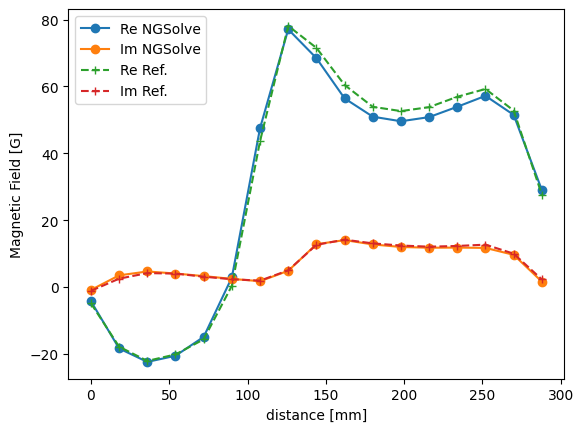

In [75]:
import matplotlib.pyplot as plt
plt.plot(1e3*x, B_re_50Hz[:,2], '-o', label="Re NGSolve")
plt.plot(1e3*x, B_im_50Hz[:,2], '-o', label="Im NGSolve")
plt.plot(1e3*x, Bz_re_50Hz_ref, '--+', label="Re Ref.")
plt.plot(1e3*x, Bz_im_50Hz_ref, '--+', label="Im Ref.")
plt.ylabel("Magnetic Field [G]")
plt.xlabel('distance [mm]')
plt.legend()